# Fifa player value predictions

## import the necessary modules

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
fifa_data = pd.read_csv("./FIFA.csv").iloc[:,3:]
fifa_data.head()

,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Preprocess the data

In [3]:
fifa_data = fifa_data.drop(["Photo", "Flag", "Club Logo"], axis=1)

### Solve the `Value`, `Wage` and `Release Clause` columns

In [4]:
import pandas as pd

def convert_value(value):
    if pd.notnull(value):
        # Check if the value is a string
        if isinstance(value, str):
            # Remove Euro symbol and leading/trailing whitespace
            value = value.replace('€', '').strip()
            
            # Check if the value ends with 'M'
            if value.endswith('M'):
                # Convert 'M' to six zeros
                value = float(value.replace('M', '')) * 1e6
            elif value.endswith('K'):
                # Convert 'K' to three zeros
                value = float(value.replace('K', '')) * 1e3
        
        return value

    return value

fifa_data['Value'] = fifa_data['Value'].apply(convert_value).astype(float).astype(int)
fifa_data['Wage'] = fifa_data['Wage'].apply(convert_value).astype(float).astype(int)
fifa_data['Release Clause'] = fifa_data['Release Clause'].apply(convert_value).astype(float)

### Replace missing values as shown below

In [5]:
import pandas as pd

def fix_missing_values(data):
    # Fill the numeric missing values with median
    numeric_cols = data.select_dtypes(include=["int", "float"]).columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

    # Fill the string missing values with mode
    string_cols = data.select_dtypes(include=["object"]).columns
    for col in string_cols:  # Get the first mode from the Series
        data[col] = data[col].fillna("Unknown")

    return data

# Call the function to fix missing values
fifa_data = fix_missing_values(fifa_data)

In [6]:
fifa_data["Body Type"] = fifa_data["Body Type"].replace(
{
  'Messi': 'Unknown', 'C. Ronaldo': 'Unknown', 'Neymar': 'Unknown', 'Courtois': 'Unknown',
  'PLAYER_BODY_TYPE_25': 'Unknown', 'Shaqiri': 'Unknown', 'Akinfenwa': 'Unknown',  
})

### Generate dummy variables for the categorical variables

In [7]:
# Use the to_datetime function to parse the dates and extract the year
fifa_data["Joined"] = pd.to_datetime(fifa_data["Joined"], errors="coerce").dt.year

In [8]:
fifa_data["Joined"] = fifa_data["Joined"].fillna(fifa_data["Joined"].median()) # Replace with the median

In [9]:
fifa_data["Joined"].value_counts()

2018.0    6569
2017.0    5860
2016.0    2246
2015.0    1336
2014.0     818
2013.0     458
2012.0     340
2011.0     201
2010.0     131
2009.0      78
2008.0      53
2007.0      38
2006.0      18
2005.0      17
2003.0      13
2004.0      12
2002.0      10
1998.0       3
2001.0       2
2000.0       2
1991.0       1
1999.0       1
Name: Joined, dtype: int64

In [10]:
print("Number of Categories:")
for col in fifa_data.select_dtypes(include='object').columns.to_list():
    print(col, fifa_data[col].nunique())

Number of Categories:
Nationality 164
Club 652
Preferred Foot 3
Work Rate 10
Body Type 4
Real Face 3
Position 28
Loaned From 342
Contract Valid Until 37
Height 22
Weight 58
LS 94
ST 94
RS 94
LW 106
LF 103
CF 103
RF 103
RW 106
LAM 102
CAM 102
RAM 102
LM 101
LCM 93
CM 93
RCM 93
RM 101
LWB 96
LDM 100
CDM 100
RDM 100
RWB 96
LB 99
LCB 109
CB 109
RCB 109
RB 99


In [11]:
fifa_data["Joined"] = fifa_data["Joined"].astype(int)

In [12]:
# Generate dummy variables for the categorical columns
def generate_dummy(data=fifa_data):
    for col in data.select_dtypes(include='object').columns.to_list():
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
        data.drop(col, axis=1, inplace=True) 
    return data
fifa_data = generate_dummy()

### Separate the features and the label

In [13]:
y = fifa_data.pop("Value")
X = fifa_data

In [14]:
# Turn the data into numpy arrays
X, y = X.values, y.values

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [15]:
X_train.shape, X_val.shape, X_test.shape

((10241, 3975), (4552, 3975), (3414, 3975))

### Scale the data

In [16]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale X_test and X_train
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Scale y_train and y_test
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

## Fit XGboost regressor

The default parameters for the `XGBRegressor` in the XGBoost library can vary depending on the version of XGBoost, here are some of the commonly used default parameters:

1. `objective`: 'reg:squarederror' (default for regression tasks).
2. `n_estimators`: 100 (the number of boosting rounds).
3. `learning_rate`: 0.3 (shrinkage applied to each update to prevent overfitting).
4. `max_depth`: 6 (maximum depth of a tree).
5. `min_child_weight`: 1 (minimum sum of instance weight needed in a child).
6. `gamma`: 0 (minimum loss reduction required to make a further partition on a leaf node).
7. `subsample`: 1.0 (fraction of samples used for fitting trees).
8. `colsample_bytree`: 1.0 (fraction of features used for fitting trees).
9. `reg_alpha`: 0 (L1 regularization term on weights).
10. `reg_lambda`: 1 (L2 regularization term on weights).
11. `base_score`: 0.5 (the initial prediction score of all instances).
12. `scale_pos_weight`: 1 (controls the balance of positive and negative weights, typically used in imbalanced classes).

Please note that the default parameters may change in newer versions of XGBoost, and it's a good practice to check the official documentation or use the `get_params()` method on an `XGBRegressor` instance to see the default values for your specific version of the library. To create an `XGBRegressor` with default parameters, you can simply initialize it without passing any arguments like this:

```python
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor()
```

You can then modify individual parameters as needed for your specific problem and dataset.

In [17]:
from xgboost import XGBRegressor

XGBRegressor().get_params() # These are the default parameters

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Optimizing XGBoost parameters
Optimizing the hyperparameters of an XGBoost regressor involves using techniques like Grid Search or Random Search. Below is an example of how to perform hyperparameter optimization using Grid Search with Python and the `GridSearchCV` function from the Scikit-learn library.

First, make sure you have the necessary libraries installed. You can install them using pip:

```bash
pip install xgboost scikit-learn
```

This code performs a grid search over various hyperparameters of the XGBoost regressor and finds the combination that minimizes the mean squared error on a cross-validated dataset. You can replace the dataset loading part with your own data and adapt the parameter grid to your specific needs.

Remember to adjust the parameter grid, cross-validation settings, and dataset according to your problem and computational resources. Grid search can be computationally expensive, so consider using a more targeted search or techniques like Random Search for larger hyperparameter spaces.

In [18]:
# from sklearn.model_selection import GridSearchCV

# # Load your dataset or create one for demonstration
# # X, y = load_data()

# # Split the dataset into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the parameter grid to search through
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 2, 3],
#     'gamma': [0, 0.1, 0.2],
# }

# # Initialize the XGBoost regressor
# xgb_regressor = XGBRegressor()

# # Create the Grid Search object
# grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = np.sqrt(-grid_search.best_score_)

# print("Best Parameters:", best_params)
# print("Best RMSE Score:", best_score)

# # Train the XGBoost model with the best parameters on the full training set
# best_xgb_regressor = XGBRegressor(**best_params)
# best_xgb_regressor.fit(X_train, y_train)

# # Evaluate the model on the test set
# y_pred = best_xgb_regressor.predict(X_val)

# # Calculate the test set RMSE
# test_rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
# print("Test Set RMSE:", test_rmse)

Training Error:     0.011355421678249529
Validation Error:   0.028168127929257564
Test Error:         0.0282737474053016


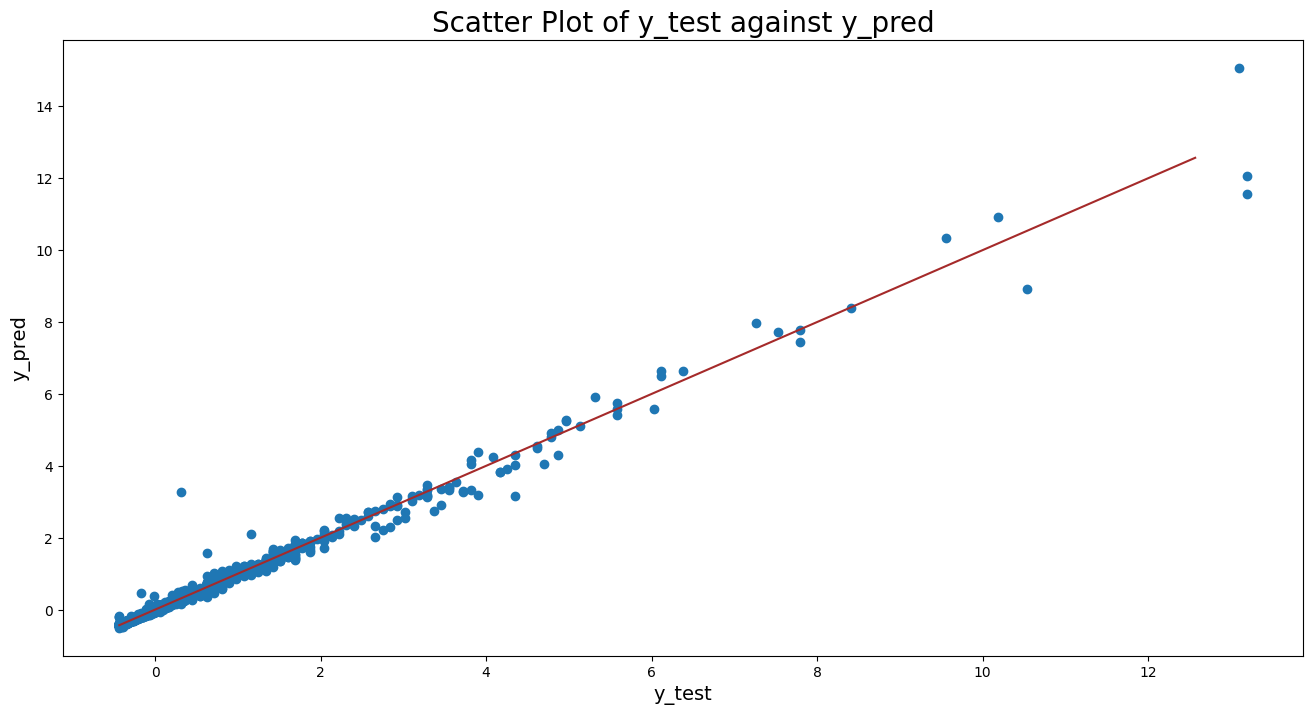

In [19]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

def fit_and_print(p=XGBRegressor(), X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test):
    # Fit the transformer
    p.fit(X_train, y_train)
    # Predict the train and test outputs
    training_prediction = p.predict(X_train)
    val_prediction =p.predict(X_val)
    test_pred = p.predict(X_test)
    
    # Print the errors
    print("Training Error:     "+str(mean_absolute_error(training_prediction, y_train)))
    print("Validation Error:   "+str(mean_absolute_error(val_prediction, y_val)))
    print("Test Error:         "+str(mean_absolute_error(test_pred, y_test)))
    
    
    plt.figure(figsize=(16,8))
    plt.scatter(y_test, test_pred)
    plt.plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), c='brown') # The QQ-plot
    plt.title("Scatter Plot of y_test against y_pred", size=20)
    plt.xlabel("y_test", size=14)
    plt.ylabel("y_pred", size=14)
    plt.show()

fit_and_print()

## Fit a DNN Regression model and evaluate the model

### Training Deep Neural Networks
- Challenges of training a deep neural network:
> * Vanishing gradients problem/ Exploding Gradients problem - When gradients get lower and lower or greater and greater
> * Not enough training data/ too costly to label
> * Training maybe too slow
> * Overfitting risk
### Solution
#### Glorot and He Initialization
- Signal to flow properly ; variance of the outputs of each layer to be equal to variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.
> * Xavier/ Glorot Initialization - Using Glorot initialization can speed up training considerably.
> * He Initialization should be used with Relu and its variants
> * SELU activation function should be used with LeCun initialization, prefarably with normal distribution.
> * By default, Keras uses Glorot initialization with a uniform distribution
> * When creating a layer, you can change this to He initialization by setting:
    `kernel_initializer="he_uniform` or `kernel_initializer="he_normal`:
    `python
    keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal"
    `
    If you want He intialization with uniform distribution but based on fan-avg rather than fan-in, you can use the variance scaling initializer:
    `python
    he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
    keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)
    `

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=X_train.shape[1:]), # Input and first layer
    tf.keras.layers.Dense(1) # Output layer
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')

# Fit the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

# Evaluate the model
eval_test = model.evaluate(X_test, y_test)

print("Eval metrics", eval_test)

Epoch 1/30
321/321 [==============================] - 2s 4ms/step - loss: 0.6917 - val_loss: 0.7708
Epoch 2/30
321/321 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 3/30
321/321 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 4/30
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 5/30
321/321 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 6/30
321/321 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 7/30
321/321 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 8/30
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 9/30
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 10/30
321/321 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 11/30
321/321 [==============================] 

### Why is there nan?

The issue we're facing where the loss becomes "nan" (not-a-number) during training typically indicates a problem with the training data or model configuration. Here are some common reasons why this might happen and how you can address them:

1. **Data Preprocessing**: One possible reason is that there may be missing or poorly formatted data in your training, validation, or test sets. Make sure that your input data is properly cleaned, and there are no missing or infinite values.

2. **Learning Rate**: The learning rate used by your optimizer may be too high. A large learning rate can lead to overshooting and unstable training. You can try reducing the learning rate to see if it helps. You can do this by specifying the learning rate when creating the optimizer, for example:

   ```python
   optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
   ```

3. **Normalization**: Ensure that your input features are properly normalized. Neural networks often perform better when the input data is scaled to a small range (e.g., between 0 and 1 or -1 and 1). You can use tools like `sklearn.preprocessing.StandardScaler` to standardize your input features.

4. **Loss Function**: The choice of loss function can also impact training. The "mean squared error" loss is suitable for regression tasks, but if your data or problem has specific characteristics, you might want to explore other loss functions.

5. **Model Architecture**: The architecture of your neural network might not be appropriate for your problem. Make sure that the model is not too complex for the amount of data you have. Overfitting can lead to loss values becoming "nan." You may need to add regularization techniques like dropout or reduce the model's complexity.

6. **Data Quality**: Check the data quality and consistency, as outliers or incorrect data points can lead to training instability.

7. **Validation Data**: It's important to check the validation data for similar issues, as the loss on the validation set can also go "nan." If it does, consider looking at the validation data and ensure it's properly formatted and doesn't have issues.

8. **Random Initialization**: Sometimes, the weights in the neural network are initialized poorly, leading to convergence problems. You can experiment with different weight initialization methods (e.g., Glorot, He initialization) to see if it helps.

9. **Early Stopping**: Implement early stopping during training to prevent the model from overfitting or getting stuck in a poor local minimum. TensorFlow's `tf.keras.callbacks.EarlyStopping` can be used for this purpose.

10. **Regularization**: Consider adding L1 or L2 regularization to your model. Regularization can help prevent overfitting.

To debug the exact issue, you might want to examine the data and training process more closely, look for extreme values, and try some of the suggested steps to improve training stability.

In [21]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [22]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [23]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [24]:
# Use a different learning rate
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(80, activation="relu", input_shape=X_train.shape[1:]), # Input and first layer
    tf.keras.layers.Dense(1) # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

# Evaluate the model
eval_test = model.evaluate(X_test, y_test)

print("Eval metrics", eval_test)

Epoch 1/30
321/321 [==============================] - 2s 5ms/step - loss: 0.9625 - val_loss: 0.7153
Epoch 2/30
321/321 [==============================] - 2s 5ms/step - loss: 0.8739 - val_loss: 0.4517
Epoch 3/30
321/321 [==============================] - 1s 5ms/step - loss: 0.3188 - val_loss: 0.4001
Epoch 4/30
321/321 [==============================] - 2s 5ms/step - loss: 0.1772 - val_loss: 0.3401
Epoch 5/30
321/321 [==============================] - 2s 7ms/step - loss: 0.1205 - val_loss: 0.3149
Epoch 6/30
321/321 [==============================] - 2s 6ms/step - loss: 0.0991 - val_loss: 0.2961
Epoch 7/30
321/321 [==============================] - 2s 5ms/step - loss: 0.0876 - val_loss: 0.2817
Epoch 8/30
321/321 [==============================] - 2s 6ms/step - loss: 0.0798 - val_loss: 0.2723
Epoch 9/30
321/321 [==============================] - 2s 5ms/step - loss: 0.0739 - val_loss: 0.2675
Epoch 10/30
321/321 [==============================] - 2s 5ms/step - loss: 0.0689 - val_loss: 0.2573

Selecting the best activation function, kernel initializer, and the number of layers for an Artificial Neural Network (ANN) regression task depends on various factors, including the nature of your dataset, the complexity of the problem, and available computational resources. Here are some guidelines to help you make these choices:

1. **Activation Functions**:
   - **ReLU (Rectified Linear Unit)**: This is a good starting point for most cases. It is computationally efficient and works well in practice.
   - **Sigmoid or Hyperbolic Tangent (tanh)**: These activation functions are suitable for the output layer when you need to constrain the predictions within a specific range, such as (0, 1) for sigmoid or (-1, 1) for tanh.
   - **Leaky ReLU or Parametric ReLU (PReLU)**: These variants of ReLU can be used to address the vanishing gradient problem in deep networks.
   - **Swish**: Swish has shown promise in some cases, but its performance can vary depending on the dataset.

2. **Kernel Initializers**:
   - **Xavier/Glorot Initialization**: This is a good default choice for most cases. It helps maintain the variance of activations, which can be important for training deep networks.
   - **He Initialization**: This is a good choice for ReLU and its variants. It helps prevent the dying ReLU problem.
   - **RandomNormal or RandomUniform**: These can be used for experimentation, but be cautious with very large or very small initializations.

3. **Number of Layers**:
   - The number of layers in your ANN should be determined through experimentation. Start with a small network and gradually increase the complexity if needed. It's crucial to prevent overfitting, especially with limited data.
   - You can start with a simple architecture (e.g., one or two hidden layers) and then gradually add more layers if your model underfits the data.
   - Use techniques like cross-validation to evaluate different architectures and prevent overfitting.

4. **Regularization and Dropout**:
   - Consider using L1 and L2 regularization to prevent overfitting, especially with deep networks.
   - Dropout can help improve generalization by randomly dropping a fraction of neurons during training.

5. **Batch Size and Learning Rate**:
   - Experiment with different batch sizes and learning rates to find the combination that works best for your dataset. Smaller batch sizes may help with convergence, while larger batch sizes can be more efficient in terms of computation.

6. **Optimizers**:
   - Adam and RMSprop are popular optimizers for most regression tasks, but you can also experiment with other optimizers like SGD.

7. **Scaling and Normalization**:
   - Make sure to preprocess your data by scaling and normalizing it. Standardization (mean=0, std=1) often works well.

8. **Monitor Model Performance**:
   - Use appropriate evaluation metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), or R-squared to assess your model's performance.

9. **Grid Search or Random Search**:
   - Consider using grid search or random search to systematically explore various hyperparameter combinations.

10. **Cross-Validation**:
   - Implement cross-validation to ensure the generalization performance of your model.

In practice, there is no one-size-fits-all solution, and the choice of activation functions, kernel initializers, and the number of layers should be based on empirical experimentation. You should also consider the size and quality of your dataset and the specific characteristics of your regression problem.

In [25]:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'), # First Layer
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'), # Second Layer
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
321/321 [==============================] - 3s 6ms/step - loss: 0.7968 - mae: 0.5461 - val_loss: 0.5818 - val_mae: 0.4392
Epoch 2/100
321/321 [==============================] - 2s 5ms/step - loss: 0.4763 - mae: 0.3602 - val_loss: 0.5115 - val_mae: 0.3653
Epoch 3/100
321/321 [==============================] - 2s 7ms/step - loss: 0.3046 - mae: 0.2988 - val_loss: 0.4332 - val_mae: 0.3361
Epoch 4/100
321/321 [==============================] - 2s 7ms/step - loss: 0.1461 - mae: 0.2458 - val_loss: 0.4149 - val_mae: 0.3182
Epoch 5/100
321/321 [==============================] - 2s 6ms/step - loss: 0.1115 - mae: 0.2177 - val_loss: 0.4276 - val_mae: 0.3231
Epoch 6/100
321/321 [==============================] - 2s 5ms/step - loss: 0.0941 - mae: 0.2029 - val_loss: 0.3713 - val_mae: 0.3017
Epoch 7/100
321/321 [==============================] - 2s 5ms/step - loss: 0.0819 - mae: 0.1900 - val_loss: 0.3558 - val_mae: 0.2966
Epoch 8/100
321/321 [==============================] - 2s 7ms/step - 

321/321 [==============================] - 2s 5ms/step - loss: 0.0065 - mae: 0.0566 - val_loss: 0.2315 - val_mae: 0.2465
Epoch 63/100
321/321 [==============================] - 2s 5ms/step - loss: 0.0063 - mae: 0.0559 - val_loss: 0.2335 - val_mae: 0.2461
Epoch 64/100
321/321 [==============================] - 2s 5ms/step - loss: 0.0062 - mae: 0.0550 - val_loss: 0.2307 - val_mae: 0.2461
Epoch 65/100
321/321 [==============================] - 2s 6ms/step - loss: 0.0060 - mae: 0.0541 - val_loss: 0.2312 - val_mae: 0.2460
Epoch 66/100
321/321 [==============================] - 2s 7ms/step - loss: 0.0058 - mae: 0.0535 - val_loss: 0.2310 - val_mae: 0.2459
Epoch 67/100
321/321 [==============================] - 2s 7ms/step - loss: 0.0057 - mae: 0.0526 - val_loss: 0.2310 - val_mae: 0.2457
Epoch 68/100
321/321 [==============================] - 2s 6ms/step - loss: 0.0055 - mae: 0.0519 - val_loss: 0.2287 - val_mae: 0.2459
Epoch 69/100
321/321 [==============================] - 2s 5ms/step - loss:

In [26]:
# Evaluate the model
eval_test = model.evaluate(X_test, y_test)

print("Eval metrics", eval_test)

107/107 [==============================] - 0s 3ms/step - loss: 0.2311 - mae: 0.2486
Eval metrics [0.23114897310733795, 0.2485773265361786]


### Fine-Tuning Neural Networks Hyperparameters

In [27]:
# Option 1: Use GridSearchCV
#This function creates a simple Sequential model for univariate regression

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-2, input_shape=X_train.shape[1:]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [28]:
# create a KerasRegressor based on this build_model() function:
keras_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# Now we can use this object like a regular Scikit-Learn
# regressor: we can train it using its fit() method, then evaluate it using its
# score() method, and use it to make predictions using its predict() method,
# as you can see in the following code:
keras_model.fit(X_train, y_train, epochs=100,
               validation_data=(X_val, y_val),
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

# Evaluate your model
mse_score = keras_model.score(X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Epoch 1/100
321/321 [==============================] - 2s 4ms/step - loss: nan - val_loss: nan
Epoch 2/100
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 3/100
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 4/100
321/321 [==============================] - 2s 5ms/step - loss: nan - val_loss: nan
Epoch 5/100
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 6/100
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 7/100
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 8/100
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 9/100
321/321 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 10/100
107/107 [==============================] - 0s 3ms/step - loss: nan


In [29]:
# from scipy.stats import reciprocal
# from sklearn.model_selection import RandomizedSearchCV

# param_distribs = {
#     "n_hidden": [0,1,2,3],
#     "n_neurons": np.arange(1,100),
#     "learning_rate": reciprocal(3e-4, 3e-2),
# }

# rnd_search_cv = RandomizedSearchCV(keras_model, param_distribs, n_iter=10, cv=3)
# rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
#                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [30]:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(100, activation='elu'), # First Layer
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(100, activation='elu'), # Second Layer
    tf.keras.layers.Dense(100, activation='elu'), # Third Layer
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00032)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
321/321 [==============================] - 4s 9ms/step - loss: 0.9830 - mae: 0.5545 - val_loss: 0.7817 - val_mae: 0.4822
Epoch 2/100
321/321 [==============================] - 2s 7ms/step - loss: 0.5978 - mae: 0.4425 - val_loss: 0.6242 - val_mae: 0.4080
Epoch 3/100
321/321 [==============================] - 2s 7ms/step - loss: 0.4179 - mae: 0.3833 - val_loss: 0.5351 - val_mae: 0.3737
Epoch 4/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3127 - mae: 0.3432 - val_loss: 0.4788 - val_mae: 0.3534
Epoch 5/100
321/321 [==============================] - 2s 6ms/step - loss: 0.2483 - mae: 0.3140 - val_loss: 0.4412 - val_mae: 0.3365
Epoch 6/100
321/321 [==============================] - 2s 6ms/step - loss: 0.2080 - mae: 0.2916 - val_loss: 0.4162 - val_mae: 0.3189
Epoch 7/100
321/321 [==============================] - 2s 6ms/step - loss: 0.1819 - mae: 0.2725 - val_loss: 0.3962 - val_mae: 0.3071
Epoch 8/100
321/321 [==============================] - 2s 6ms/step - 

321/321 [==============================] - 2s 8ms/step - loss: 0.0282 - mae: 0.1137 - val_loss: 0.2108 - val_mae: 0.2001
Epoch 63/100
321/321 [==============================] - 2s 8ms/step - loss: 0.0277 - mae: 0.1129 - val_loss: 0.2096 - val_mae: 0.1996
Epoch 64/100
321/321 [==============================] - 2s 6ms/step - loss: 0.0273 - mae: 0.1120 - val_loss: 0.2071 - val_mae: 0.1992
Epoch 65/100
321/321 [==============================] - 2s 6ms/step - loss: 0.0268 - mae: 0.1113 - val_loss: 0.2087 - val_mae: 0.1986
Epoch 66/100
321/321 [==============================] - 2s 6ms/step - loss: 0.0263 - mae: 0.1105 - val_loss: 0.2059 - val_mae: 0.1981
Epoch 67/100
321/321 [==============================] - 2s 6ms/step - loss: 0.0259 - mae: 0.1096 - val_loss: 0.2063 - val_mae: 0.1975
Epoch 68/100
321/321 [==============================] - 2s 6ms/step - loss: 0.0255 - mae: 0.1090 - val_loss: 0.2057 - val_mae: 0.1969
Epoch 69/100
321/321 [==============================] - 2s 6ms/step - loss:

In [31]:
model.evaluate(X_test, y_test)

107/107 [==============================] - 0s 3ms/step - loss: 0.1772 - mae: 0.1821


[0.17721667885780334, 0.18210206925868988]

107/107 [==============================] - 0s 3ms/step
Training Error:     0.08931996072277387
Validation Error:   0.18490394867156057
Test Error:         0.18196353705724055


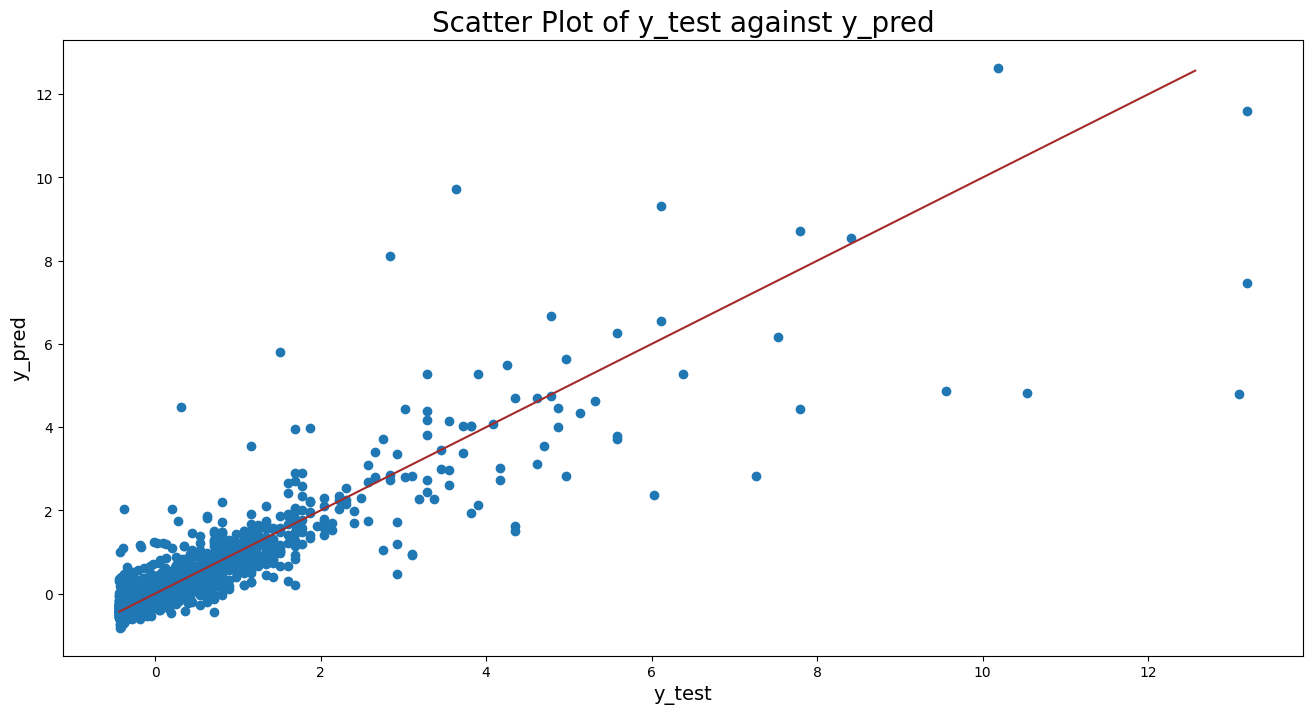

In [32]:
fit_and_print(p=model)

### Faster Optimizers

- Ways to speed up Training:
1. **Applying a good initialization strategy for the connection weights**
2. **Using a good activation function**
3. **Using Batch Normalization**
4. **Reusing parts of a pretrained network**
5. **Using a faster optimizer than the regular Gradient Descent optimizer**

Here are some of the optimizers to be explored:
1. **Momentum Optimizer**
2. **Nesterov Accelerated Gradient**
3. **AdaGrad**
4. **RMSProp**
5. **Adam Optimization**
6. **Nadam Optimization**

#### Momentum Optimization
- Cares about what previous gradients were:
- * **At each iteration, it subtracts the local gradient from the momentum vector m**
- * **and it updates the weights by adding this momentum vector**
- To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter called β, called momentum which must be set between 0 (high friction) to 1 (no friction). A typical momentum value is 0.9.
- In DNNs that dont use Batch Normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.

In [33]:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(20, activation='elu'), # First Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'), # Second Layer
    tf.keras.layers.Dense(20, activation='elu'), # Third Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0005048339507337271, momentum=0.9)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
321/321 [==============================] - 2s 4ms/step - loss: 0.5374 - mae: 0.3631 - val_loss: 0.4892 - val_mae: 0.2749
Epoch 2/100
321/321 [==============================] - 1s 4ms/step - loss: 0.3547 - mae: 0.2564 - val_loss: 0.2931 - val_mae: 0.2240
Epoch 3/100
321/321 [==============================] - 1s 3ms/step - loss: 0.2130 - mae: 0.1933 - val_loss: 1.1988 - val_mae: 0.4247
Epoch 4/100
321/321 [==============================] - 1s 3ms/step - loss: 0.3247 - mae: 0.2346 - val_loss: 0.2319 - val_mae: 0.1988
Epoch 5/100
321/321 [==============================] - 1s 3ms/step - loss: 0.0757 - mae: 0.1443 - val_loss: 0.2104 - val_mae: 0.1819
Epoch 6/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0499 - mae: 0.1226 - val_loss: 0.2063 - val_mae: 0.1696
Epoch 7/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0412 - mae: 0.1103 - val_loss: 0.1938 - val_mae: 0.1628
Epoch 8/100
321/321 [==============================] - 1s 3ms/step - 

321/321 [==============================] - 1s 5ms/step - loss: 0.0020 - mae: 0.0325 - val_loss: 0.1450 - val_mae: 0.1237
Epoch 63/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0020 - mae: 0.0323 - val_loss: 0.1448 - val_mae: 0.1233
Epoch 64/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0020 - mae: 0.0319 - val_loss: 0.1441 - val_mae: 0.1231
Epoch 65/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0020 - mae: 0.0320 - val_loss: 0.1449 - val_mae: 0.1231
Epoch 66/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0019 - mae: 0.0313 - val_loss: 0.1441 - val_mae: 0.1227
Epoch 67/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0018 - mae: 0.0308 - val_loss: 0.1453 - val_mae: 0.1229
Epoch 68/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0018 - mae: 0.0306 - val_loss: 0.1440 - val_mae: 0.1228
Epoch 69/100
321/321 [==============================] - 1s 4ms/step - loss:

In [34]:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(20, activation='elu'), # First Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'), # Second Layer
    tf.keras.layers.Dense(20, activation='elu'), # Third Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
321/321 [==============================] - 3s 6ms/step - loss: 0.3949 - mae: 0.2899 - val_loss: 0.4376 - val_mae: 0.2874
Epoch 2/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1232 - mae: 0.1658 - val_loss: 0.2942 - val_mae: 0.1817
Epoch 3/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1233 - mae: 0.1497 - val_loss: 0.2065 - val_mae: 0.1611
Epoch 4/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0530 - mae: 0.1134 - val_loss: 0.1734 - val_mae: 0.1510
Epoch 5/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0401 - mae: 0.0999 - val_loss: 0.1673 - val_mae: 0.1455
Epoch 6/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0338 - mae: 0.0929 - val_loss: 0.1618 - val_mae: 0.1406
Epoch 7/100
321/321 [==============================] - 1s 5ms/step - loss: 0.0269 - mae: 0.0852 - val_loss: 0.1611 - val_mae: 0.1379
Epoch 8/100
321/321 [==============================] - 2s 5ms/step - 

#### Nesterov Accelerated Gradient (NAG)
- Almost always better than vanilla momentum optimization
- Measures the gradient of the cost function not at local position but in the direction of the momentum
- The Nesterov update ends up slighly closer to the optimum.
- NAG converges faster
- Generally faster than regular momentum optimization

In [35]:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(20, activation='elu'), # First Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'), # Second Layer
    tf.keras.layers.Dense(20, activation='elu'), # Third Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
321/321 [==============================] - 3s 5ms/step - loss: 0.4196 - mae: 0.3009 - val_loss: 0.2488 - val_mae: 0.2057
Epoch 2/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1252 - mae: 0.1691 - val_loss: 0.5944 - val_mae: 0.2757
Epoch 3/100
321/321 [==============================] - 2s 5ms/step - loss: 0.1419 - mae: 0.1695 - val_loss: 1.6809 - val_mae: 0.4844
Epoch 4/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1675 - mae: 0.1839 - val_loss: 0.2056 - val_mae: 0.1705
Epoch 5/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0713 - mae: 0.1305 - val_loss: 0.1604 - val_mae: 0.1522
Epoch 6/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0932 - mae: 0.1316 - val_loss: 0.1757 - val_mae: 0.1760
Epoch 7/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0420 - mae: 0.1041 - val_loss: 0.1785 - val_mae: 0.1483
Epoch 8/100
321/321 [==============================] - 1s 4ms/step - 

#### RMSProp
- AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum.
- The RMSProp fixes this by accumulating only the gradients from the most recent iterations
- It does so by using exponential decay
- The decay rate is typically set to 0.9, which often works well, you may not need to tune at all

In [36]:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(20), # First Layer
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(20), # Second Layer
    tf.keras.layers.Dense(20), # Third Layer
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
321/321 [==============================] - 2s 4ms/step - loss: 0.5719 - mae: 0.3555 - val_loss: 0.3206 - val_mae: 0.2642
Epoch 2/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1993 - mae: 0.2329 - val_loss: 0.2567 - val_mae: 0.2373
Epoch 3/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1431 - mae: 0.2029 - val_loss: 0.2395 - val_mae: 0.1983
Epoch 4/100
321/321 [==============================] - 1s 5ms/step - loss: 0.1207 - mae: 0.1859 - val_loss: 0.2449 - val_mae: 0.1882
Epoch 5/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1050 - mae: 0.1716 - val_loss: 0.1773 - val_mae: 0.1883
Epoch 6/100
321/321 [==============================] - 1s 5ms/step - loss: 0.0930 - mae: 0.1649 - val_loss: 0.1632 - val_mae: 0.2029
Epoch 7/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0866 - mae: 0.1614 - val_loss: 0.1843 - val_mae: 0.1660
Epoch 8/100
321/321 [==============================] - 1s 4ms/step - 

#### Adam Optimizer
- Adam (Adaptive Moment Estimation) combines the idea of momentum optimization and RMSProp:
- * **Just like moment optimization, it keeps track of an exponentially decaying average of past gradients**
- * **And just like RMSProp, it keeps track of an exponentially decaying average of past squared ingredients**
- The momentum decay hyperparameter is initialized to 0.9, while the scaling decay hyperparameter is often initializzed to 0.999

- Since Adam is an adaptive learning rate algorithm, it requires less tuning of the learning rate hyperparameter.

In [37]:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(20, activation='elu'), # First Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'), # Second Layer
    tf.keras.layers.Dense(20, activation='elu'), # Third Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
321/321 [==============================] - 3s 5ms/step - loss: 0.3991 - mae: 0.2494 - val_loss: 0.2879 - val_mae: 0.1783
Epoch 2/100
321/321 [==============================] - 2s 6ms/step - loss: 0.1264 - mae: 0.1452 - val_loss: 0.2170 - val_mae: 0.1565
Epoch 3/100
321/321 [==============================] - 2s 5ms/step - loss: 0.0770 - mae: 0.1167 - val_loss: 0.2025 - val_mae: 0.1412
Epoch 4/100
321/321 [==============================] - 2s 5ms/step - loss: 0.0643 - mae: 0.0972 - val_loss: 0.2122 - val_mae: 0.1475
Epoch 5/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0455 - mae: 0.0882 - val_loss: 0.1676 - val_mae: 0.1385
Epoch 6/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0316 - mae: 0.0763 - val_loss: 0.1656 - val_mae: 0.1363
Epoch 7/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0230 - mae: 0.0702 - val_loss: 0.2022 - val_mae: 0.1440
Epoch 8/100
321/321 [==============================] - 1s 4ms/step - 

### Learning Rate Scheduling

- **Power Scheduling** - Reduces learning rate more and more slowly
- **Exponential Scheduling** - Keeps slashing learning rate by a factor of 10 every s steps
- **Piecewise constant scheduling** 
- **Performance Scheduling** - Measure the validation error every N steps, and return the lr by a factor of lambda when the error stops dropping
- **1cycle Scheduling** 

In [38]:
# Implementing power scheduling in Keras is the easiest option: just set the
# decay hyperparameter when creating an optimizer:
# Create a more complex model with 2 layers and 100 neurons in each layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(20, activation='elu'), # First Layer
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'), # Second Layer
    tf.keras.layers.Dense(20, activation='elu'), # Third Layer
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=1e-4)
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
321/321 [==============================] - 2s 5ms/step - loss: 0.4597 - mae: 0.2905 - val_loss: 0.3726 - val_mae: 0.2251
Epoch 2/100
321/321 [==============================] - 1s 4ms/step - loss: 0.3682 - mae: 0.1852 - val_loss: 0.5816 - val_mae: 0.2634
Epoch 3/100
321/321 [==============================] - 1s 4ms/step - loss: 0.2016 - mae: 0.1637 - val_loss: 0.2599 - val_mae: 0.1718
Epoch 4/100
321/321 [==============================] - 1s 4ms/step - loss: 0.2573 - mae: 0.1438 - val_loss: 0.2255 - val_mae: 0.1636
Epoch 5/100
321/321 [==============================] - 1s 4ms/step - loss: 0.1914 - mae: 0.1247 - val_loss: 0.2277 - val_mae: 0.1613
Epoch 6/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0650 - mae: 0.0985 - val_loss: 0.2057 - val_mae: 0.1486
Epoch 7/100
321/321 [==============================] - 1s 4ms/step - loss: 0.0924 - mae: 0.0874 - val_loss: 0.2315 - val_mae: 0.1545
Epoch 8/100
321/321 [==============================] - 1s 4ms/step - 

#### Exponential Scheduling

In [39]:
# Implementing exponential scheduling
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(100, activation='elu'), # First Layer
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(1) # Output Layer
])

# Compile the model
model.compile(loss="mse", metrics='mae', optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/100
321/321 [==============================] - 3s 7ms/step - loss: 1.2776 - mae: 0.4685 - val_loss: 0.7880 - val_mae: 0.3450 - lr: 0.0100
Epoch 2/100
321/321 [==============================] - 2s 6ms/step - loss: 0.7922 - mae: 0.3432 - val_loss: 0.7909 - val_mae: 0.3795 - lr: 0.0089
Epoch 3/100
321/321 [==============================] - 2s 6ms/step - loss: 0.7117 - mae: 0.3053 - val_loss: 0.7426 - val_mae: 0.3563 - lr: 0.0079
Epoch 4/100
321/321 [==============================] - 2s 6ms/step - loss: 0.6801 - mae: 0.2764 - val_loss: 0.7085 - val_mae: 0.2997 - lr: 0.0071
Epoch 5/100
321/321 [==============================] - 2s 6ms/step - loss: 0.6637 - mae: 0.2632 - val_loss: 0.6947 - val_mae: 0.2747 - lr: 0.0063
Epoch 6/100
321/321 [==============================] - 2s 6ms/step - loss: 0.6487 - mae: 0.2504 - val_loss: 0.6912 - val_mae: 0.3151 - lr: 0.0056
Epoch 7/100
321/321 [==============================] - 3s 9ms/step - loss: 0.6349 - mae: 0.2391 - val_loss: 0.6725 - val_mae

Epoch 56/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3855 - mae: 0.1322 - val_loss: 0.4378 - val_mae: 0.1858 - lr: 1.7783e-05
Epoch 57/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3854 - mae: 0.1316 - val_loss: 0.4378 - val_mae: 0.1858 - lr: 1.5849e-05
Epoch 58/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3851 - mae: 0.1319 - val_loss: 0.4376 - val_mae: 0.1858 - lr: 1.4125e-05
Epoch 59/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3850 - mae: 0.1311 - val_loss: 0.4377 - val_mae: 0.1858 - lr: 1.2589e-05
Epoch 60/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3848 - mae: 0.1310 - val_loss: 0.4378 - val_mae: 0.1859 - lr: 1.1220e-05
Epoch 61/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3847 - mae: 0.1315 - val_loss: 0.4377 - val_mae: 0.1858 - lr: 1.0000e-05
Epoch 62/100
321/321 [==============================] - 2s 6ms/step - loss: 0.3846 - mae: 0.13

### Avoiding Overfitting through Regularization

#### l1 and l2 Regularization

- You can use l2 regularization to constrain a neural network's conection weights, and/or l1 regularization if you want a sparse model

#### Dropout
- At every training step, every neuron (including input neurons, but always excluding the output neurons) has a probability of being temporarily dropped out.
- The hyperparameter p is called the dropout rate and is typically set btn 10% and 50%.
- After training, neurons don't get dropped anymore
- A unique neural network is generated at each training step
- In practice, you can usually apply dropout only to the neurons in the top one to three layers (Excluding the output layer)

In [44]:
# Use a different learning rate
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    keras.layers.Dropout(rate=0.2), # Use the droput Regularizer
    tf.keras.layers.Dense(80, activation="relu"), # first layer
    keras.layers.Dropout(rate=0.2), # Use the droput Regularizer
    tf.keras.layers.Dense(80, activation="relu"), # first layer
    keras.layers.Dropout(rate=0.2), # Use the droput Regularizer
    tf.keras.layers.Dense(1) # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='mean_squared_error', metrics=["mae"], optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

# Evaluate the model
eval_test = model.evaluate(X_test, y_test)

print("Eval metrics", eval_test)

Epoch 1/30
321/321 [==============================] - 5s 12ms/step - loss: 1.1273 - mae: 0.6624 - val_loss: 0.4876 - val_mae: 0.3728
Epoch 2/30
321/321 [==============================] - 3s 11ms/step - loss: 0.6160 - mae: 0.4620 - val_loss: 0.4304 - val_mae: 0.3248
Epoch 3/30
321/321 [==============================] - 3s 11ms/step - loss: 0.4611 - mae: 0.4029 - val_loss: 0.3679 - val_mae: 0.2840
Epoch 4/30
321/321 [==============================] - 4s 11ms/step - loss: 0.3438 - mae: 0.3538 - val_loss: 0.3425 - val_mae: 0.2636
Epoch 5/30
321/321 [==============================] - 4s 11ms/step - loss: 0.3256 - mae: 0.3344 - val_loss: 0.3312 - val_mae: 0.2433
Epoch 6/30
321/321 [==============================] - 4s 11ms/step - loss: 0.2872 - mae: 0.3093 - val_loss: 0.3184 - val_mae: 0.2370
Epoch 7/30
321/321 [==============================] - 3s 11ms/step - loss: 0.2851 - mae: 0.3025 - val_loss: 0.4397 - val_mae: 0.2674
Epoch 8/30
321/321 [==============================] - 3s 11ms/step - 

#### Monte Carlo (MC) Dropout
- Can boost the performance of any trained dropout model without having to retrain it or even modify it at all
- Provides a much better measure of the model's uncertainty 
- Amazingly simple to implement

In [45]:
# Implementation
y_probas = np.stack([model(X_test, training=True)
                    for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_proba

array([[-0.06162841],
       [-0.3247825 ],
       [ 1.578248  ],
       ...,
       [-0.5184119 ],
       [-0.3796677 ],
       [ 0.65628505]], dtype=float32)

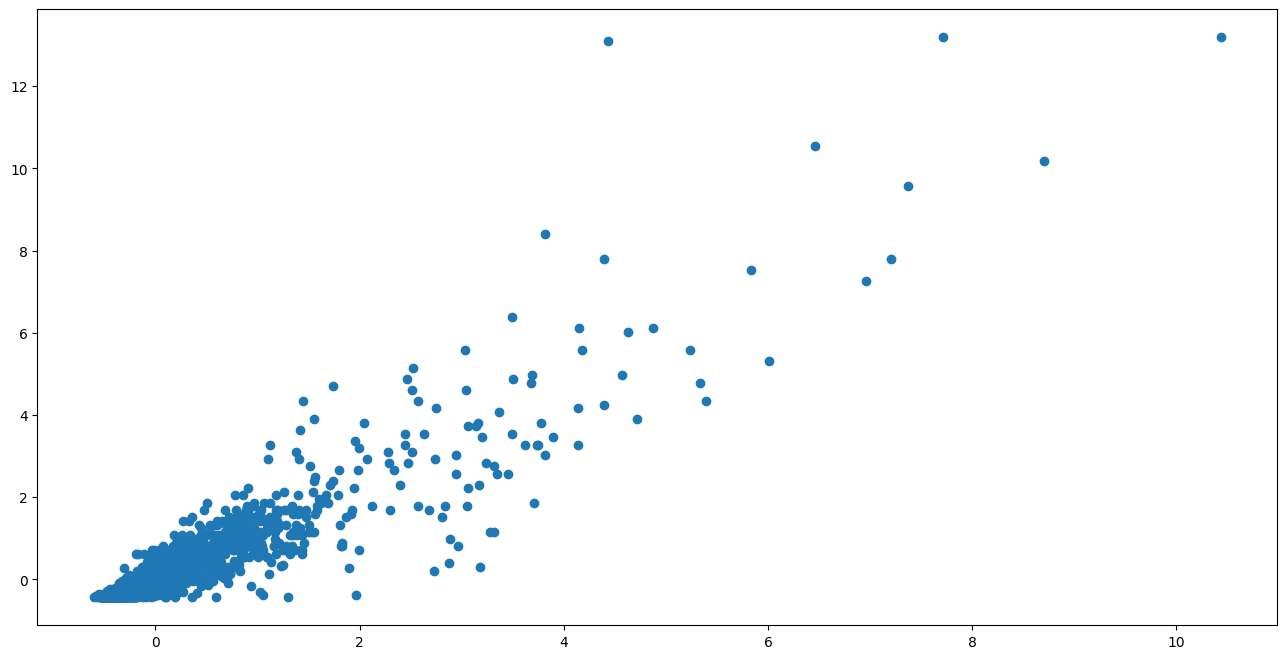

In [47]:
plt.figure(figsize=(16, 8))
plt.scatter(y_proba, y_test)

#### Max-Norm Regularization

- Does not add a regularization loss term to the overall loss function.
- Instead it is typically implemented by computing ||w||2 after each training step and rescaling w if needed.
- To implement max-norm regularization in keras, set the kernel_constraint argument of each hidden layer to a max_norm() constraint with the appropriate max value

In [48]:
# Use a different learning rate
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(80, activation="relu", kernel_constraint=keras.constraints.max_norm(1.)), # first layer
    tf.keras.layers.Dense(80, activation="relu", kernel_constraint=keras.constraints.max_norm(1.)), # first layer
    tf.keras.layers.Dense(1) # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='mean_squared_error', metrics=["mae"], optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val))

# Evaluate the model
eval_test = model.evaluate(X_test, y_test)

print("Eval metrics", eval_test)

Epoch 1/60
321/321 [==============================] - 5s 12ms/step - loss: 0.5809 - mae: 0.4309 - val_loss: 0.4385 - val_mae: 0.3550
Epoch 2/60
321/321 [==============================] - 3s 11ms/step - loss: 0.3299 - mae: 0.2950 - val_loss: 0.3560 - val_mae: 0.2982
Epoch 3/60
321/321 [==============================] - 4s 11ms/step - loss: 0.2063 - mae: 0.2378 - val_loss: 0.3340 - val_mae: 0.2825
Epoch 4/60
321/321 [==============================] - 4s 11ms/step - loss: 0.1076 - mae: 0.2064 - val_loss: 0.3136 - val_mae: 0.2688
Epoch 5/60
321/321 [==============================] - 4s 12ms/step - loss: 0.0807 - mae: 0.1846 - val_loss: 0.2894 - val_mae: 0.2627
Epoch 6/60
321/321 [==============================] - 3s 11ms/step - loss: 0.0679 - mae: 0.1709 - val_loss: 0.2807 - val_mae: 0.2557
Epoch 7/60
321/321 [==============================] - 3s 10ms/step - loss: 0.0595 - mae: 0.1603 - val_loss: 0.2684 - val_mae: 0.2515
Epoch 8/60
321/321 [==============================] - 3s 10ms/step - 

#### 1Cycle Scheduling

In [49]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [53]:
# Use a different learning rate
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(80, activation="elu", kernel_initializer='he_normal'), # first layer
    tf.keras.layers.Dense(80, activation="elu", kernel_initializer='he_normal'), # first layer
    tf.keras.layers.Dense(1) # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss='mean_squared_error', metrics=["mae"], optimizer=optimizer)

Epoch 1/100
81/81 [==============================] - 2s 14ms/step - loss: 2.9857 - mae: 1.1691
Epoch 2/100
81/81 [==============================] - 1s 15ms/step - loss: 2.0710 - mae: 1.0158
Epoch 3/100
81/81 [==============================] - 1s 13ms/step - loss: 1.5848 - mae: 0.9091
Epoch 4/100
81/81 [==============================] - 1s 12ms/step - loss: 1.2749 - mae: 0.8266
Epoch 5/100
81/81 [==============================] - 1s 12ms/step - loss: 1.0524 - mae: 0.7572
Epoch 6/100
81/81 [==============================] - 1s 12ms/step - loss: 0.8788 - mae: 0.6964
Epoch 7/100
81/81 [==============================] - 1s 12ms/step - loss: 0.7392 - mae: 0.6412
Epoch 8/100
81/81 [==============================] - 1s 12ms/step - loss: 0.6288 - mae: 0.5931
Epoch 9/100
81/81 [==============================] - 1s 12ms/step - loss: 0.5398 - mae: 0.5501
Epoch 10/100
81/81 [==============================] - 2s 19ms/step - loss: 0.4656 - mae: 0.5113
Epoch 11/100
81/81 [=============================

81/81 [==============================] - 1s 14ms/step - loss: nan - mae: nan
Epoch 90/100
81/81 [==============================] - 1s 15ms/step - loss: nan - mae: nan
Epoch 91/100
81/81 [==============================] - 1s 15ms/step - loss: nan - mae: nan
Epoch 92/100
81/81 [==============================] - 1s 15ms/step - loss: nan - mae: nan
Epoch 93/100
81/81 [==============================] - 1s 14ms/step - loss: nan - mae: nan
Epoch 94/100
81/81 [==============================] - 1s 13ms/step - loss: nan - mae: nan
Epoch 95/100
81/81 [==============================] - 1s 12ms/step - loss: nan - mae: nan
Epoch 96/100
81/81 [==============================] - 1s 13ms/step - loss: nan - mae: nan
Epoch 97/100
81/81 [==============================] - 1s 12ms/step - loss: nan - mae: nan
Epoch 98/100
81/81 [==============================] - 1s 15ms/step - loss: nan - mae: nan
Epoch 99/100
81/81 [==============================] - 1s 15ms/step - loss: nan - mae: nan
Epoch 100/100
81/81 [==

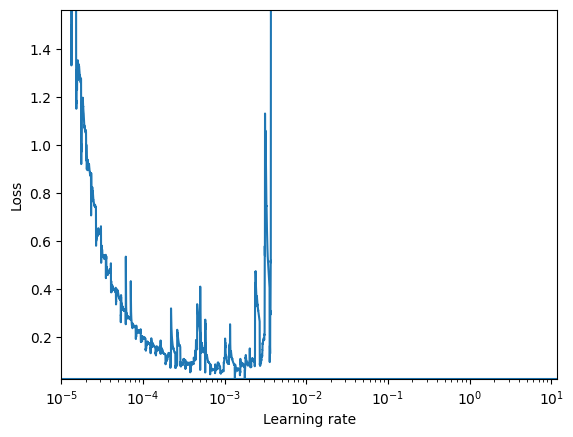

In [54]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=100, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [59]:
# Use a different learning rate
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]), # Input Layer
    tf.keras.layers.Dense(80, activation="elu", kernel_initializer='he_normal'), # first layer
    tf.keras.layers.Dense(80, activation="elu", kernel_initializer='he_normal'),
    tf.keras.layers.Dense(80, activation="elu", kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1) # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss='mean_squared_error', metrics=["mae"], optimizer=optimizer)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
         callbacks=tf.keras.callbacks.EarlyStopping(patience=10))

Epoch 1/100
321/321 [==============================] - 4s 11ms/step - loss: 1.0191 - mae: 0.6489 - val_loss: 0.5955 - val_mae: 0.4539
Epoch 2/100
321/321 [==============================] - 3s 10ms/step - loss: 0.3480 - mae: 0.3653 - val_loss: 0.4686 - val_mae: 0.3894
Epoch 3/100
321/321 [==============================] - 3s 10ms/step - loss: 0.2412 - mae: 0.3016 - val_loss: 0.4232 - val_mae: 0.3629
Epoch 4/100
321/321 [==============================] - 4s 11ms/step - loss: 0.1577 - mae: 0.2615 - val_loss: 0.5681 - val_mae: 0.3847
Epoch 5/100
321/321 [==============================] - 3s 10ms/step - loss: 0.1453 - mae: 0.2458 - val_loss: 0.3771 - val_mae: 0.3387
Epoch 6/100
321/321 [==============================] - 3s 10ms/step - loss: 0.1084 - mae: 0.2216 - val_loss: 0.3664 - val_mae: 0.3169
Epoch 7/100
321/321 [==============================] - 3s 10ms/step - loss: 0.0842 - mae: 0.2007 - val_loss: 0.3463 - val_mae: 0.3091
Epoch 8/100
321/321 [==============================] - 3s 9ms/

Epoch 62/100
321/321 [==============================] - 3s 10ms/step - loss: 0.0071 - mae: 0.0619 - val_loss: 0.2279 - val_mae: 0.2441
Epoch 63/100
321/321 [==============================] - 3s 9ms/step - loss: 0.0069 - mae: 0.0609 - val_loss: 0.2271 - val_mae: 0.2438
Epoch 64/100
321/321 [==============================] - 3s 9ms/step - loss: 0.0067 - mae: 0.0603 - val_loss: 0.2273 - val_mae: 0.2435
Epoch 65/100
321/321 [==============================] - 3s 9ms/step - loss: 0.0066 - mae: 0.0597 - val_loss: 0.2264 - val_mae: 0.2433
Epoch 66/100
321/321 [==============================] - 3s 9ms/step - loss: 0.0064 - mae: 0.0589 - val_loss: 0.2259 - val_mae: 0.2433
Epoch 67/100
321/321 [==============================] - 3s 8ms/step - loss: 0.0063 - mae: 0.0584 - val_loss: 0.2256 - val_mae: 0.2427
Epoch 68/100
321/321 [==============================] - 3s 9ms/step - loss: 0.0061 - mae: 0.0577 - val_loss: 0.2251 - val_mae: 0.2426
Epoch 69/100
321/321 [==============================] - 3s 9m